# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Нам нужно будет построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. Проведем небольшой исследовательский анализ данных, а именно:
1. Проверим размер выборки
2. Посмотрим на график распределения возраста в выборке
3. Оценим качество 10-15 фотографий.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


При загрузке данных получили 7591 файл. Этого может быть достаточно для обучения нейросети. Проверим распределение целевого признака (возраст).

In [3]:
# на всякий случай проверим типы данных и наличие пропусков
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


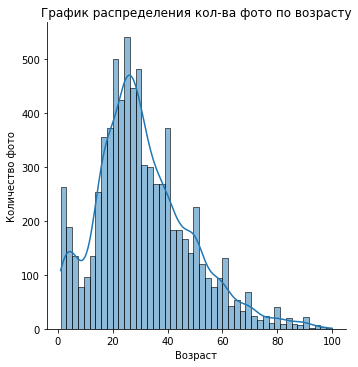

In [4]:
# строим график распределения возрастов
ax = sns.displot(labels['real_age'], kde=True);
ax.set(xlabel='Возраст', ylabel='Количество фото', title='График распределения кол-ва фото по возрасту');

График распределен приблизительно нормально, хотя и завален влево и имеет спад количества фото в районе 10 лет. Фотографий пожилых людей мало, что выглядит логичным, так как средняя продолжительность жизни имеет определенные границы в зависимости от страны, поэтому количество очень старых людей не будет большим. А для анализа возраста при продаже 18+ товаров это вовсе не сыграет роль, так как нужно определять несовершеннолетних.

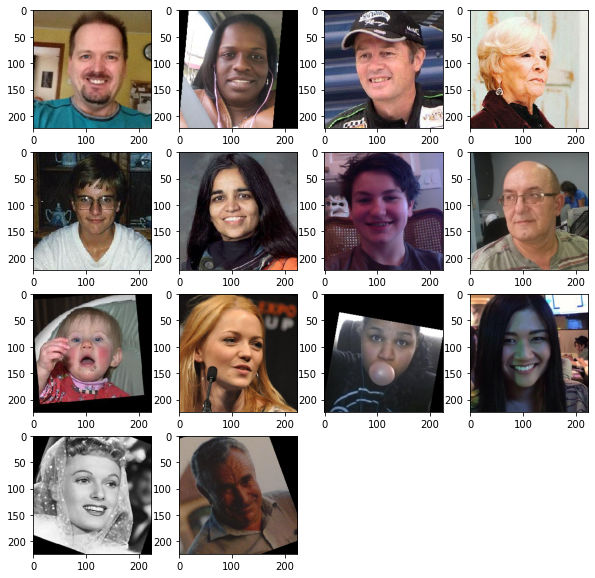

In [5]:
# выведем первые 14 фотографий
fig = plt.figure(figsize=(10,10))
for i in range(14):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(train_gen_flow[0][0][i])

Насколько видим, фотографии действительно отображают людей, лица видны. Некоторые фото повернуты, но это не должно помешать, так как аугментации скорее всего придется делать. На основе таких данных предположительно можно обучить нейросеть для поставленных задач.

## Обучение модели

Ниже представлен код и результат обучения на облачном GPU. Нейросеть построена на архитектуре Resnet50 с использованием предобученных весов датасета ImageNet, чтобы повысить качество.

```python

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)

    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels, 
                                                     directory=path + 'final_files/', 
                                                     target_size=(224, 224),                                                   
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='training', 
                                                     seed=12345, 
                                                     x_col='file_name', 
                                                     y_col='real_age')


    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    val_datagen_flow = datagen.flow_from_dataframe(dataframe=labels, 
                                                   directory=path + 'final_files/', 
                                                   target_size=(224, 224), 
                                                   batch_size=16, 
                                                   class_mode='raw', 
                                                   subset='validation', 
                                                   seed=12345,
                                                   x_col='file_name', 
                                                   y_col='real_age')


    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    optimizer = Adam(lr=0.0001)
    
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs,
            batch_size=batch_size)

    return model

```

Вывод результатов обучения (большая часть тех. информации вырезана):

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-05-29 11:36:14.989243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-29 11:36:15.358259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 215.1745 - mae: 10.4803 - val_loss: 764.7761 - val_mae: 22.5431
Epoch 2/10
356/356 - 43s - loss: 83.3389 - mae: 6.9598 - val_loss: 114.7877 - val_mae: 8.1528
Epoch 3/10
356/356 - 42s - loss: 58.8465 - mae: 5.8624 - val_loss: 91.2343 - val_mae: 7.1904
Epoch 4/10
356/356 - 42s - loss: 42.7524 - mae: 5.0063 - val_loss: 76.4290 - val_mae: 6.4376
Epoch 5/10
356/356 - 43s - loss: 31.3552 - mae: 4.3484 - val_loss: 92.2839 - val_mae: 7.3306
Epoch 6/10
356/356 - 42s - loss: 23.8285 - mae: 3.7260 - val_loss: 67.9097 - val_mae: 6.2427
Epoch 7/10
356/356 - 42s - loss: 20.7067 - mae: 3.4722 - val_loss: 64.4248 - val_mae: 6.0079
Epoch 8/10
356/356 - 42s - loss: 16.3592 - mae: 3.0915 - val_loss: 77.1240 - val_mae: 6.8498
Epoch 9/10
356/356 - 43s - loss: 15.6016 - mae: 3.0089 - val_loss: 65.1640 - val_mae: 5.9140
Epoch 10/10
356/356 - 43s - loss: 13.2642 - mae: 2.7787 - val_loss: 62.6059 - val_mae: 5.9272
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 62.6059 - mae: 5.9272
Test MAE: 5.9272

```

## Анализ обученной модели

В качестве вывода проделанной работы кратно подведем итоги. В ходе создания и обучения нейросети мы провели небольшой исследовательский анализ данных, после чего обучили модель на архитектуре Resnet50 и получили MAE на тестовой выборке, равную **5,9272**. Это хороший результат, который также легко интерпретировать. Средняя абсолютная ошибка по сути обозначает среднее расхождение реального возраста с решением нейросети, значит, в среднем модель ошибается примерно на **6 лет**. Для категоризации возрастной группы такая ошибка почти не окажет влияния. Для определения совершеннолетия на пограничных областях (16-20 лет) возможны ошибки, так как молодые люди и девушки в целом не всегда выглядят на свой реальный возраст. 

В качестве рекомендации для второй задачи исследования могу предложить обучить нейросеть с другим подходом, а именно решить задачу бинарной классификации, где задача будет не предполагать конкретный возраст, а просто отнести человека к двум категориям: несовершеннолетние и совершеннолетние.